In [1]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard 
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.clear_session()

In [3]:
# Get images
X = []
for filename in os.listdir('Train/'):
    X.append(img_to_array(load_img('Train/'+filename)))
X = np.array(X, dtype=float)
Xtrain = 1.0/255*X


#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()
print('Load weights completed!')

Instructions for updating:
Colocations handled automatically by placer.
Load weights completed!


In [4]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [5]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
# Note: we use 100 training images in total
batch_size = 32

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model.compile(optimizer='adam', loss='mse')
hist = model.fit_generator(image_a_b_gen(batch_size), epochs=50, steps_per_epoch=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
32/32 [==============================] - 94s 3s/step - loss: 0.0353
Epoch 2/50
32/32 [==============================] - 86s 3s/step - loss: 0.0106
Epoch 3/50
32/32 [==============================] - 84s 3s/step - loss: 0.0105
Epoch 4/50
32/32 [==============================] - 84s 3s/step - loss: 0.0102
Epoch 5/50
32/32 [==============================] - 85s 3s/step - loss: 0.0103
Epoch 6/50
32/32 [==============================] - 86s 3s/step - loss: 0.0101
Epoch 7/50
32/32 [==============================] - 84s 3s/step - loss: 0.0100
Epoch 8/50
32/32 [==============================] - 85s 3s/step - loss: 0.0098
Epoch 9/50
32/32 [==============================] - 85s 3s/step - loss: 0.0098
Epoch 10/50
32/32 [==============================] - 85s 3s/step - loss: 0.0097
Epoch 11/50
32/32 [==============================] - 84s 3s/step - loss: 0.0096
Epoch 12/50
32/32 [==============================] - 84s 3s/step - loss: 0.0096
E

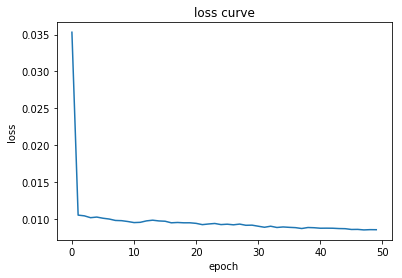

In [9]:
# Plot the loss curve
import matplotlib.pyplot as plt
import numpy

plt.plot(hist.history['loss'])
plt.title('loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('loss.jpg')

In [11]:
color_me = []
for filename in os.listdir('Test/'):
    color_me.append(img_to_array(load_img('Test/'+filename)))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
